# Clustering data points with search algorithms
#### Due to the stochasticity of the applied algorithms the results can vary a lot between different execution runs. Please feel free to alter the parameters and/or apply the algorithms over and over again.
### import the three metaheuristic algorithms

In [1]:
from bat import BatAlgorithm
from bees import BeesAlgorithm
from firefly import FireflyAlgorithm, SortedFireflyAlgorithm # two variants with time complexities of O(Tn^2) and O(Tnlogn)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### define an auxiliary function for the k-means clustering loss depending on the data points

In [3]:
def create_cluster_loss(X, k):
    def cluster_loss(x):
        centers = np.split(x, k)
        dists = np.zeros((len(centers), len(X)))
        for i in range(len(centers)):
            dists[i] = np.sqrt(np.sum(np.square(X-centers[i]), axis=1))
        return np.sum(np.min(dists, axis=0))
    
    return cluster_loss

### define a second auxiliary function for plotting data points with given cluster centers

In [6]:
from sklearn.decomposition import PCA

def plot_clustered_data(X, centers):
    dists = np.zeros((len(centers), len(X)))
    for i in range(len(centers)):
        dists[i] = np.sqrt(np.sum(np.square(X-centers[i]), axis=1))
    respons = np.argmin(dists, axis=0)
    if X.shape[1] > 2:
        pca = PCA(2).fit_transform(np.concatenate([X, centers], axis=0))
        
    X = pca[:-len(centers)]
    centers = pca[-len(centers):]
    
    plt.title('clustered data points')
    plt.scatter(X.T[0], X.T[1], c=respons)
    centers = np.array(centers)
    plt.scatter(centers.T[0], centers.T[1], c='black', marker='X')
    plt.show()

# Example 1: Clustering iris data set:

### import the iris data set

In [7]:
from sklearn.datasets import load_iris
iris_data = load_iris()['data']
iris_labels = load_iris()['target']

### plot the ground truth cluster assignments

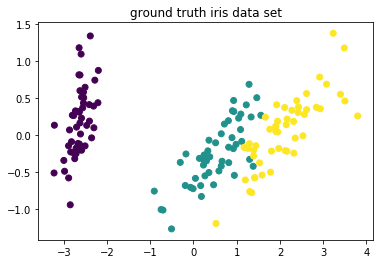

In [17]:
plt.title('ground truth iris data set')
iris_data_pca = PCA(2).fit_transform(iris_data)
plt.scatter(iris_data_pca.T[0], iris_data_pca.T[1], c=iris_labels)
plt.show()

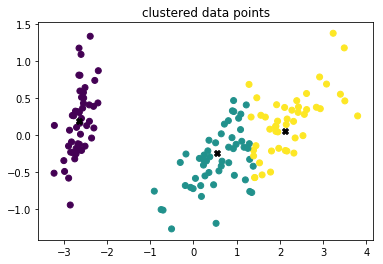

In [18]:
true_centers = np.array([np.mean(iris_data[np.where(iris_labels == label)], axis=(0)) for label in set(iris_labels)])
plot_clustered_data(iris_data, true_centers)

### algorithm-independent parameters

In [19]:
objective = 'min'
n = iris_data.shape[0]
k = 3
d_iris = iris_data.shape[1] * k # we concatenate all k cluster centers to one vector, i.e. k times 4 dimensions in iris data set
range_min  = -5.0
range_max = 5.0
T = 200

### create the clustering loss function

In [20]:
iris_loss = create_cluster_loss(iris_data, k=k)
iris_loss(true_centers)

97.66414620852757

### algorithm-dependent parameters and instantiations (for iris data)

In [21]:
bees = BeesAlgorithm(d=d_iris, n=n, range_min=range_min, range_max=range_max,
                     nb=50, ne=20, nrb=5, nre=10, shrink_factor=0.8, stgn_lim=5)

bat = BatAlgorithm(d=d_iris, n=n, range_min=range_min, range_max=range_max,
                   a=0.5, r=0.5, q_min=0.0, q_max=3.0)

firefly = SortedFireflyAlgorithm(d=d_iris, n=n, range_min=range_min, range_max=range_max,
                           alpha=1.0, beta0=1.0, gamma=0.5)

### apply bees algorithm and plot the cluster assignments

(array([ 4.65470108,  3.2469041 ,  1.55738281,  0.01766878,  5.        ,
        2.56883812,  4.65963781,  1.68974943, -1.91420604, -2.07194373,
       -3.60040544, -0.49580235]), 195.73545576261995)
15.9804601


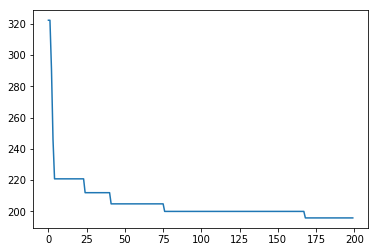

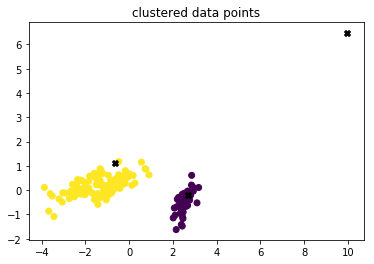

In [22]:
solution_iris, latency_iris = bees.search(objective, iris_loss, T)
solution_iris_x, solution_iris_y = solution_iris
print(solution_iris)
print(latency_iris)
bees.plot_history()

centers_iris = np.split(solution_iris_x, k)
plot_clustered_data(iris_data, centers_iris)

### apply bat algorithm and plot the cluster assignments

(array([ 5.        ,  2.83964352,  4.70573516,  1.58688631,  4.54458298,
       -1.39313343,  2.3613161 , -4.41931713,  5.        ,  3.40644748,
        1.46811743,  0.24715399]), 184.7768991375388)
11.635124899999994


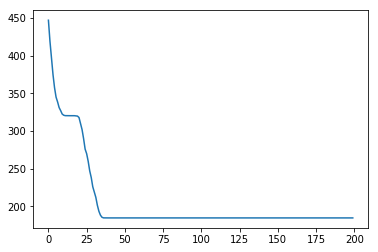

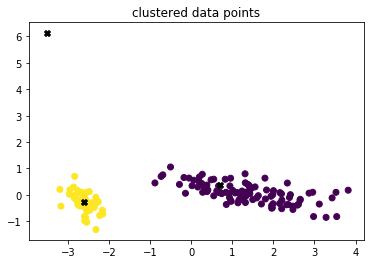

In [23]:
solution_iris, latency_iris = bat.search(objective, iris_loss, T)
solution_iris_x, solution_iris_y = solution_iris
print(solution_iris)
print(latency_iris)
bat.plot_history()

centers_iris = np.split(solution_iris_x, k)
plot_clustered_data(iris_data, centers_iris)

### apply firefly algorithm and plot the cluster assignments

(array([ 9.5506064 ,  4.17906548,  1.16121136, -1.18999678,  5.76400003,
        3.20310998,  2.97541649,  1.75476349,  0.75092872, -1.73204026,
        4.76966656,  3.95536168]), 336.9780846010747)
4.276143300000001


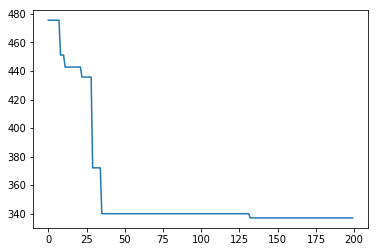

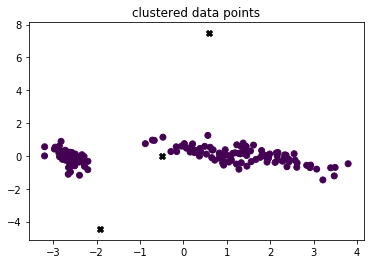

In [28]:
solution_iris, latency_iris = firefly.search(objective, iris_loss, T)
solution_iris_x, solution_iris_y = solution_iris
print(solution_iris)
print(latency_iris)
firefly.plot_history()

centers_iris = np.split(solution_iris_x, k)
plot_clustered_data(iris_data, centers_iris)

# Example 2: Clustering random data set:

### define another auxiliary function for creating a random clustering dataset, with n samples, m features and a given number of clusters

In [42]:
def create_random_cluster_dataset(n, m, num_clusters, range_min, range_max):
    means = np.random.uniform(range_min, range_max, (num_clusters, m))
    covs = [np.diag(np.random.uniform(range_min, range_max, m)) + np.random.uniform(range_min, range_max, 1)*np.eye(m).T for i in range(num_clusters)]
    sizes = np.sort(np.random.choice(np.arange(n-1), num_clusters-1, replace=False))
    sizes = [(sizes[i] if i<len(sizes) else n-1)-(sizes[i-1] if i>0 else -1) for i in range(len(sizes)+1)]
    data_per_cluster = [np.random.multivariate_normal(means[i], covs[i], size=sizes[i]) for i in range(num_clusters)]
    return np.concatenate(data_per_cluster), np.concatenate([np.repeat(i, sizes[i]) for i in range(num_clusters)])

### create a random clustering dataset with n samples, m features and k clusters

In [43]:
n = 300
m = 4
k = 3
random_data, random_labels = create_random_cluster_dataset(n, m, k, -5.0, 5.0)

C:\Users\Jonas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


### plot the ground truth cluster assignments

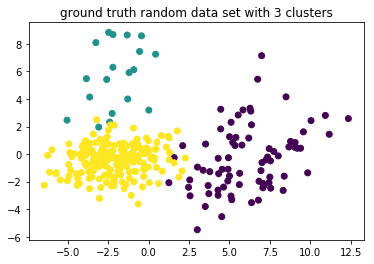

In [44]:
plt.title(f'ground truth random data set with {k} clusters')
random_data_pca = PCA(2).fit_transform(random_data)
plt.scatter(random_data_pca.T[0], random_data_pca.T[1], c=random_labels)
plt.show()

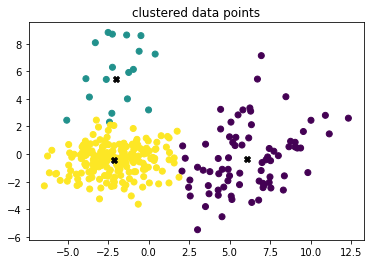

In [45]:
true_centers = np.array([np.mean(random_data[np.where(random_labels == label)], axis=(0)) for label in set(random_labels)])
plot_clustered_data(random_data, true_centers)

### create the clustering loss function

In [46]:
random_loss = create_cluster_loss(random_data, k=k)
random_loss(true_centers)

758.879484237242

### algorithm-independent parameters

In [47]:
objective = 'min'
d_random = m * k # we concatenate all k cluster centers to one vector
range_min  = -5.0
range_max = 5.0
T = 200

### algorithm-dependent parameters and instantiations (for random data)

In [48]:
bees = BeesAlgorithm(d=d_random, n=n, range_min=range_min, range_max=range_max,
                     nb=50, ne=20, nrb=5, nre=10, shrink_factor=0.8, stgn_lim=5)

bat = BatAlgorithm(d=d_random, n=n, range_min=range_min, range_max=range_max,
                   a=0.5, r=0.5, q_min=0.0, q_max=3.0)

firefly = SortedFireflyAlgorithm(d=d_random, n=n, range_min=range_min, range_max=range_max,
                           alpha=1.0, beta0=1.0, gamma=0.5)

### apply bees algorithm and plot the cluster assignments

(array([-3.8480652 ,  2.62981421, -3.94435792,  0.4802498 , -3.1105331 ,
        2.26411265, -1.39051698,  1.05344116, -3.32990692,  0.70050404,
        4.17817964,  0.89811206]), 752.2547860295789)
23.075746600000002


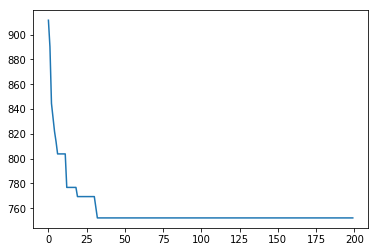

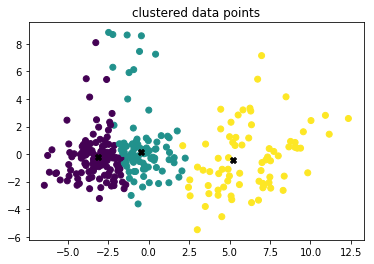

In [51]:
solution_random, latency_random = bees.search(objective, random_loss, T)
solution_random_x, solution_random_y = solution_random
print(solution_random)
print(latency_random)
bees.plot_history()

centers_random = np.split(solution_random_x, k)
plot_clustered_data(random_data, centers_random)

### apply bat algorithm and plot the cluster assignments

(array([-3.80240464,  2.17842962, -3.13671261,  0.79676827, -3.35132817,
        1.10253151,  5.        ,  1.07297747,  1.97587082,  3.1280414 ,
       -2.78690295, -2.5773391 ]), 757.6074913986768)
27.96880010000001


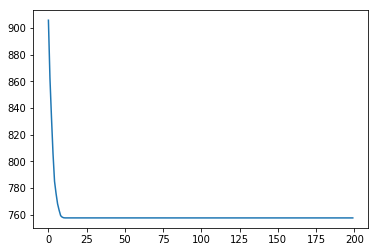

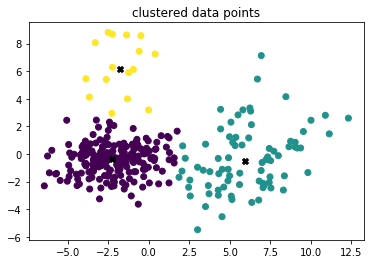

In [52]:
solution_random, latency_random = bat.search(objective, random_loss, T)
solution_random_x, solution_random_y = solution_random
print(solution_random)
print(latency_random)
bat.plot_history()

centers_random = np.split(solution_random_x, k)
plot_clustered_data(random_data, centers_random)

### apply firefly algorithm and plot the cluster assignments

(array([ 3.53595941,  4.26982368,  1.40924433, -2.74279122, -1.57094927,
       -1.17358216, -4.16727194, -1.89508492, -2.51320664, -1.00124672,
        0.2298111 , -1.68039128]), 1408.0414919540726)
9.095386699999992


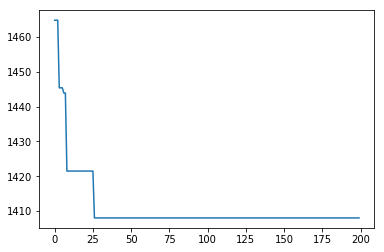

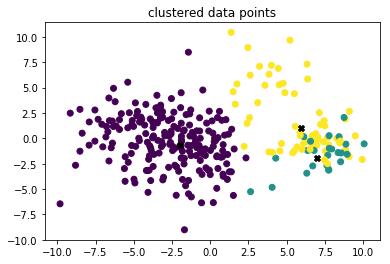

In [22]:
solution_random, latency_random = firefly.search(objective, random_loss, T)
solution_random_x, solution_random_y = solution_random
print(solution_random)
print(latency_random)
firefly.plot_history()

centers_random = np.split(solution_random_x, k)
plot_clustered_data(random_data, centers_random)